In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        self.get_block(1, 16, (3, 3), 2),
        self.get_block(16, 32, (5, 5), 2),
        self.get_block(32, 64, (5, 5), 2),
        
        nn.Flatten(),

        nn.Linear(64, 1)
    )
  
  def forward(self, x):
    return self.layers(x)

  def get_block(self, in_channel, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(.2)
    )

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super().__init__()

    self.noise_dim = noise_dim

    self.layers = nn.Sequential(
        self.get_block(noise_dim, 256, (3, 3), 2),
        self.get_block(256, 128, (4, 4), 1),
        self.get_block(128, 64, (3, 3), 2),
        self.get_block(64, 1, (4, 4), 2, True)
    )

  def forward(self, x):
    x = x.view(-1, self.noise_dim, 1, 1)
    return self.layers(x)

  def get_block(self,
                in_channels,
                out_channels,
                kernel_size, 
                stride, 
                last_block=False):
    
    if last_block:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
          nn.Tanh()
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )


In [31]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, .0, .02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, .0, .02)
    nn.init.constant_(m.bias, 0)

In [32]:
NOISE_DIM = 64

generator = Generator(NOISE_DIM).apply(weights_init).to(device)
disc = Discriminator().apply(weights_init).to(device)

In [33]:
# noise = torch.randn(size=(2, NOISE_DIM))

# images = generator(noise)
# preds = disc(images)

In [34]:
transform = T.Compose([
    T.ToTensor()
])

dataset = torchvision.datasets.MNIST(
    root='/data',
    download=True,
    train=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    batch_size=128
)

In [35]:
loss = nn.BCEWithLogitsLoss()

generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(.5, .99))
disc_optimizer = optim.Adam(disc.parameters(), lr=2e-4, betas=(.5, .99))

In [36]:
def plot_images(images):
  images = images.detach().cpu()
  fig, ax = plt.subplots(1, images.shape[0], figsize=(15, 5))

  for i in range(images.shape[0]):
    ax[i].imshow(images[i].squeeze().numpy(), cmap='gray')
  
  plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]

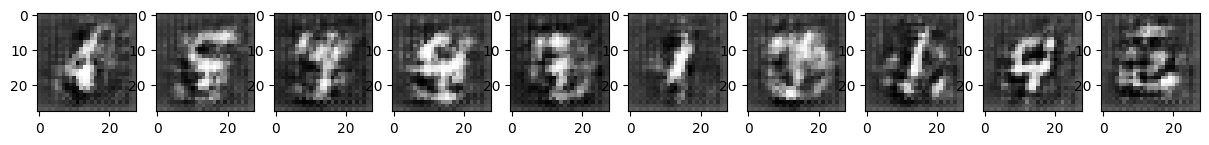

  0%|          | 0/469 [00:00<?, ?it/s]

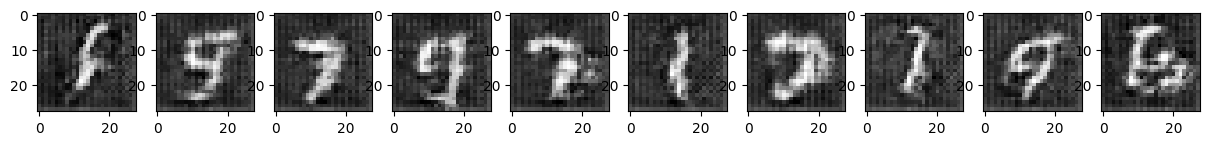

  0%|          | 0/469 [00:00<?, ?it/s]

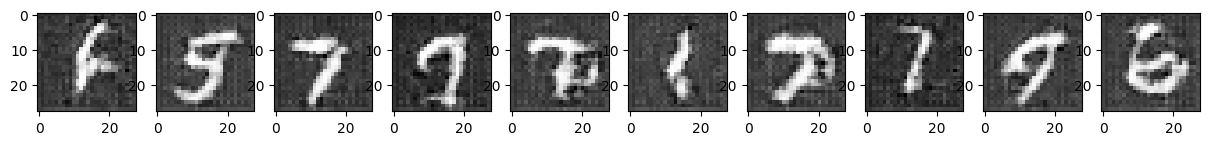

  0%|          | 0/469 [00:00<?, ?it/s]

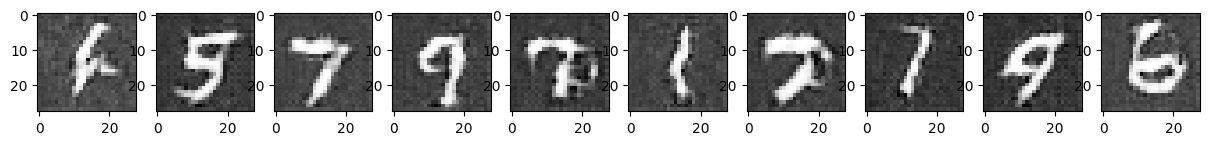

  0%|          | 0/469 [00:00<?, ?it/s]

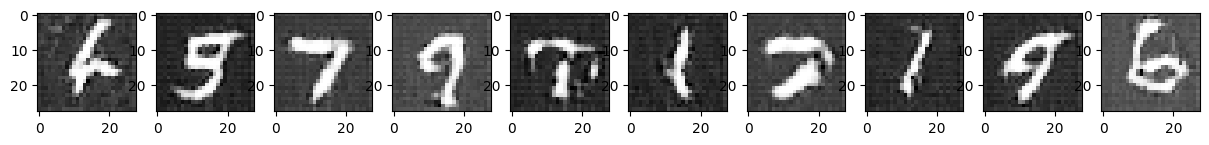

  0%|          | 0/469 [00:00<?, ?it/s]

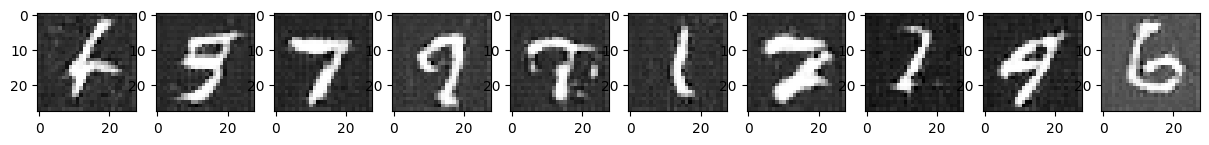

  0%|          | 0/469 [00:00<?, ?it/s]

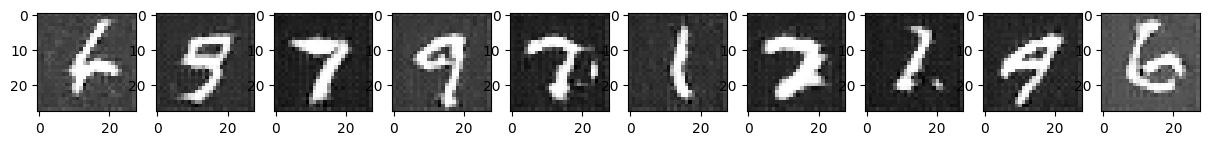

  0%|          | 0/469 [00:00<?, ?it/s]

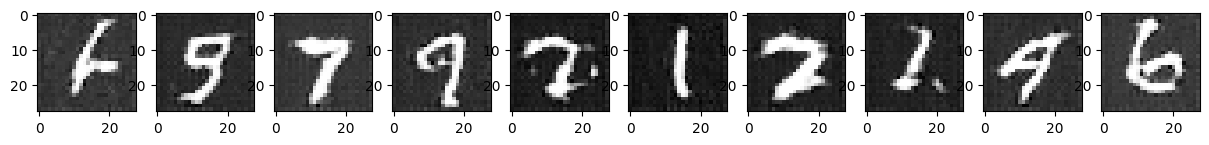

  0%|          | 0/469 [00:00<?, ?it/s]

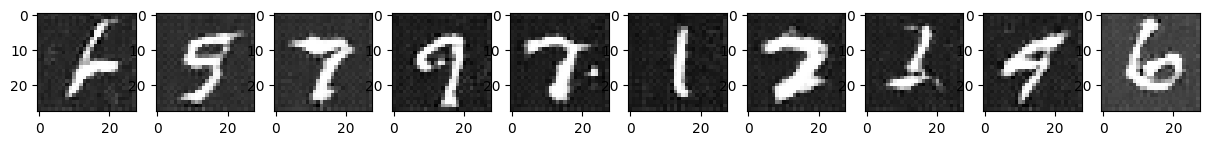

  0%|          | 0/469 [00:00<?, ?it/s]

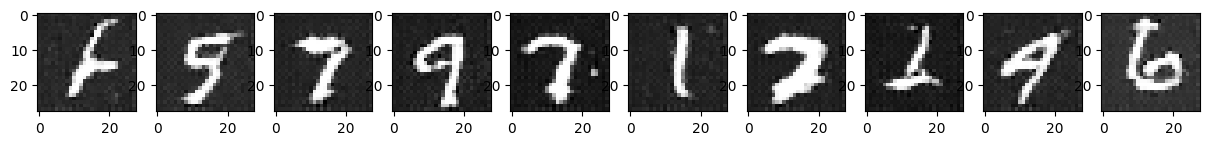

  0%|          | 0/469 [00:00<?, ?it/s]

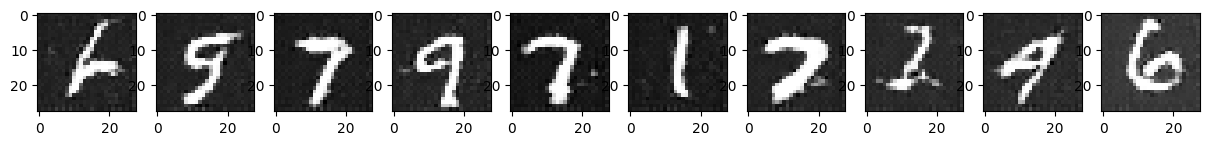

  0%|          | 0/469 [00:00<?, ?it/s]

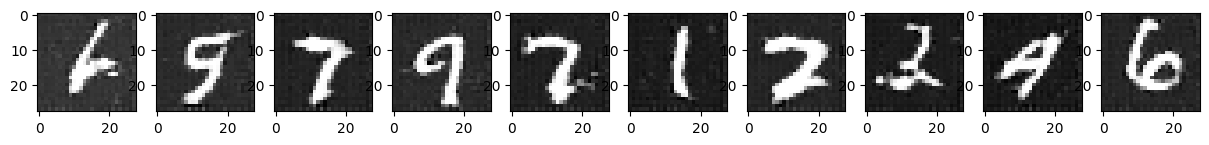

  0%|          | 0/469 [00:00<?, ?it/s]

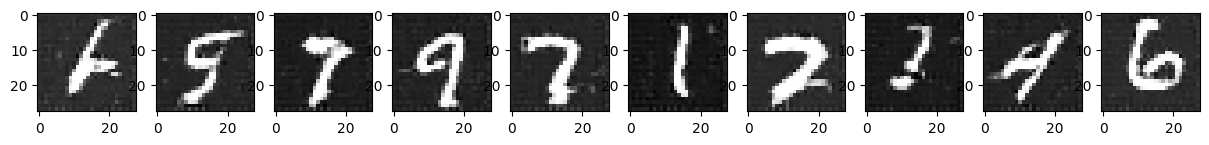

  0%|          | 0/469 [00:00<?, ?it/s]

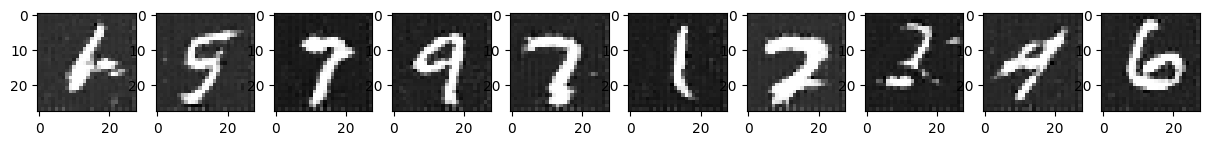

  0%|          | 0/469 [00:00<?, ?it/s]

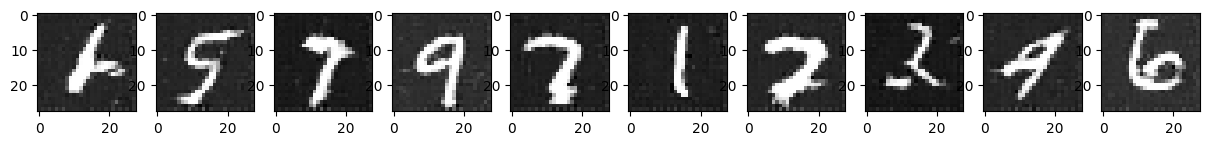

  0%|          | 0/469 [00:00<?, ?it/s]

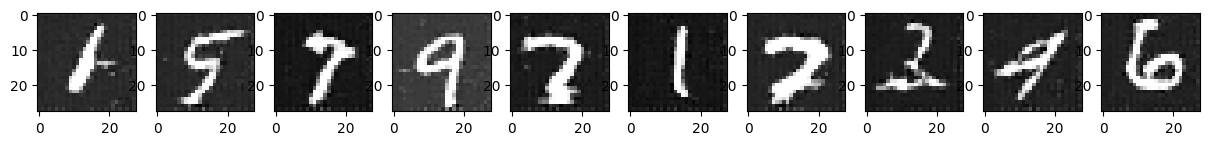

  0%|          | 0/469 [00:00<?, ?it/s]

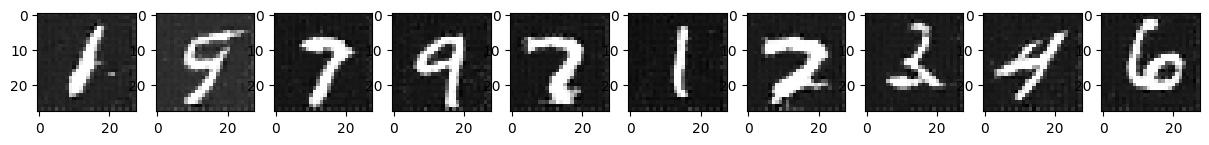

  0%|          | 0/469 [00:00<?, ?it/s]

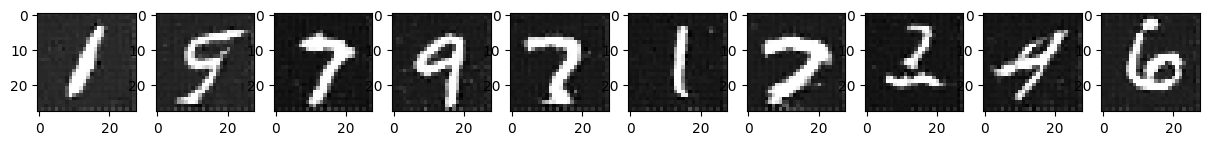

  0%|          | 0/469 [00:00<?, ?it/s]

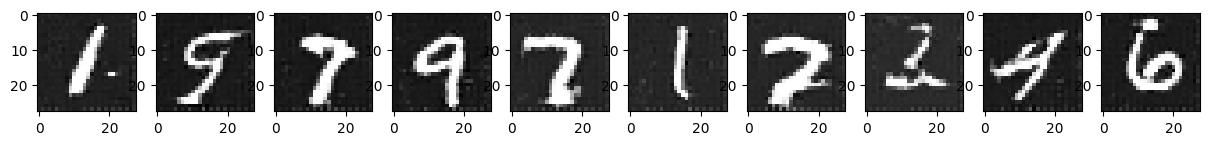

  0%|          | 0/469 [00:00<?, ?it/s]

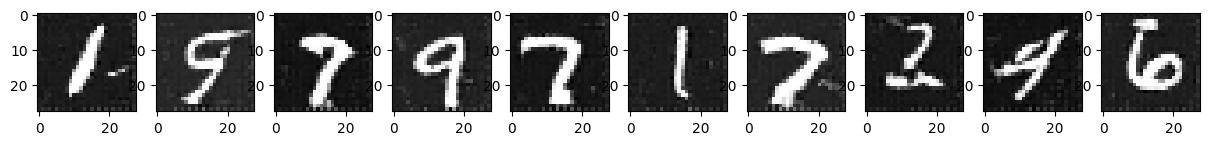

In [37]:
plot_noise = torch.randn(10, NOISE_DIM, device=device)

for i in range(20):
  for x, _ in tqdm(loader):
    x = x.to(device)
    # Disc
    disc_optimizer.zero_grad()

    real_preds = disc(x)

    noise = torch.randn(x.shape[0], NOISE_DIM, device=device)
    generated_imaegs = generator(noise)
    fake_preds = disc(generated_imaegs)

    real_labels = torch.ones_like(real_preds, device=device)
    fake_labels = torch.zeros_like(fake_preds, device=device)

    real_loss = loss(real_preds, real_labels)
    fake_loss = loss(fake_preds, fake_labels)

    total_loss = (real_loss + fake_loss) / 2

    total_loss.backward()
    disc_optimizer.step()

    # Generator
    generator_optimizer.zero_grad()

    noise = torch.randn(x.shape[0], NOISE_DIM, device=device)
    generated_imaegs = generator(noise)
    fake_preds = disc(generated_imaegs)

    fake_labels = torch.ones_like(fake_preds, device=device)

    gen_loss = loss(fake_preds, fake_labels)

    gen_loss.backward()
    generator_optimizer.step()

  images = generator(plot_noise)
  plot_images(images)